In [ ]:
#!pip install ucimlrepo



In [10]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
challenger_usa_space_shuttle_o_ring = fetch_ucirepo(id=92) 


In [39]:
import torch
import pandas as pd
import numpy as np

In [15]:
# convert to torch tensor
X = torch.tensor(challenger_usa_space_shuttle_o_ring.data.features['launch_temp'].values, dtype=torch.int64)
y = torch.tensor(challenger_usa_space_shuttle_o_ring.data.features['num_thermal_distress'].values, dtype=torch.int64)
print(X)
print(y)

tensor([66, 70, 69, 68, 67, 72, 73, 70, 57, 63, 70, 78, 67, 53, 67, 75, 70, 81,
        76, 79, 75, 76, 58])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1])


In [54]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import pyro.optim

num_classes = 3

# Model: Multinomial logistic regression (softmax regression)
def model(X, y):
    # beta0, beta1: shape (num_classes,)
    beta0 = pyro.sample("beta0", dist.Normal(torch.zeros(num_classes), 1.0 * torch.ones(num_classes)).to_event(1))
    beta1 = pyro.sample("beta1", dist.Normal(torch.zeros(num_classes), 1.0 * torch.ones(num_classes)).to_event(1))
    # Compute logits for each data point and class
    logits = beta0.unsqueeze(0) + beta1.unsqueeze(0) * X.unsqueeze(1).float()  # shape (N, num_classes)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

# Guide: Mean-field variational family
def guide(X, y):
    beta0_loc = pyro.param("beta0_loc", torch.zeros(num_classes))
    beta0_scale = pyro.param("beta0_scale", torch.ones(num_classes), constraint=dist.constraints.positive)
    beta1_loc = pyro.param("beta1_loc", torch.zeros(num_classes))
    beta1_scale = pyro.param("beta1_scale", torch.ones(num_classes), constraint=dist.constraints.positive)
    pyro.sample("beta0", dist.Normal(beta0_loc, beta0_scale).to_event(1))
    pyro.sample("beta1", dist.Normal(beta1_loc, beta1_scale).to_event(1))

# Example usage:
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_steps = 5000
for step in range(num_steps):
    loss = svi.step(X, y)
    if step % 500 == 0:
        print(f"Step {step} : loss = {loss}")

# Posterior means
print("beta0 mean:", pyro.param("beta0_loc").detach().numpy())
print("beta1 mean:", pyro.param("beta1_loc").detach().numpy())

Step 0 : loss = 2260.501220703125
Step 500 : loss = 327.91619205474854
Step 1000 : loss = 117.08938956260681
Step 1500 : loss = 207.41374444961548
Step 2000 : loss = 32.24895095825195
Step 2500 : loss = 35.16791081428528
Step 3000 : loss = 57.23072171211243
Step 3500 : loss = 48.86097526550293
Step 4000 : loss = 37.65019237995148
Step 4500 : loss = 38.73883056640625
beta0 mean: [-0.5018551  0.3753893  0.1252914]
beta1 mean: [0.07993443 0.02723878 0.02919106]


In [63]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import pyro.optim

n_trials = 6  # Each launch has 6 O-rings

# Model: Binomial regression
def model(X, y, n_trials):
    beta0 = pyro.sample("beta0", dist.Normal(0., 1.))
    beta1 = pyro.sample("beta1", dist.Normal(0., 1.))
    logits = beta0 + beta1 * X
    probs = torch.sigmoid(logits)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Binomial(total_count=n_trials, probs=probs), obs=y)

# Guide: Mean-field variational family
def guide(X, y, n_trials):
    beta0_loc = pyro.param("beta0_loc", torch.tensor(0.))
    beta0_scale = pyro.param("beta0_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    beta1_loc = pyro.param("beta1_loc", torch.tensor(0.))
    beta1_scale = pyro.param("beta1_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    pyro.sample("beta0", dist.Normal(beta0_loc, beta0_scale))
    pyro.sample("beta1", dist.Normal(beta1_loc, beta1_scale))

# Inference
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.001})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_steps = 500000
for step in range(num_steps):
    loss = svi.step(X, y, n_trials)
    if step % 50000 == 0:
        print(f"Step {step} : loss = {loss}")

# Posterior means
print("beta0 mean:", pyro.param("beta0_loc").item())
print("beta1 mean:", pyro.param("beta1_loc").item())


Step 0 : loss = 87.69886779785156
Step 50000 : loss = 130.29755651950836
Step 100000 : loss = 23.993503630161285
Step 150000 : loss = 23.54509687423706
Step 200000 : loss = 24.555720806121826
Step 250000 : loss = 23.497946798801422
Step 300000 : loss = 22.92514795064926
Step 350000 : loss = 23.28921616077423
Step 400000 : loss = 23.19675850868225
Step 450000 : loss = 24.1047602891922
beta0 mean: 0.4815977215766907
beta1 mean: -0.04785453528165817


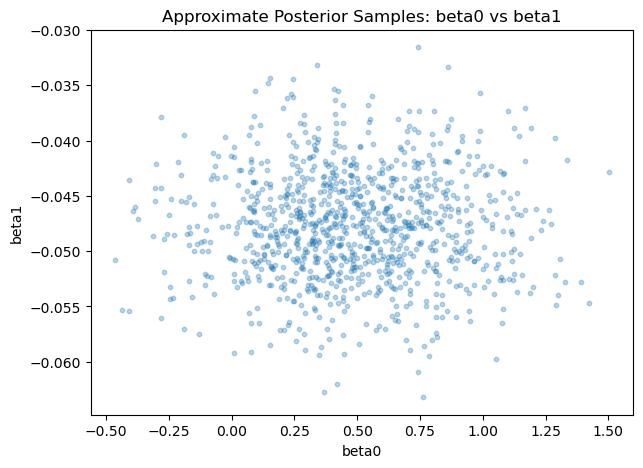

In [66]:
import matplotlib.pyplot as plt

# Get variational parameters
beta0_loc = pyro.param("beta0_loc").item()
beta0_scale = pyro.param("beta0_scale").item()
beta1_loc = pyro.param("beta1_loc").item()
beta1_scale = pyro.param("beta1_scale").item()

# Sample from the variational posterior
n_samples = 1000
beta0_samples = torch.normal(beta0_loc, beta0_scale, size=(n_samples,))
beta1_samples = torch.normal(beta1_loc, beta1_scale, size=(n_samples,))

plt.figure(figsize=(7, 5))
plt.scatter(beta0_samples, beta1_samples, alpha=0.3, s=10)
plt.xlabel("beta0")
plt.ylabel("beta1")
plt.title("Approximate Posterior Samples: beta0 vs beta1")
plt.show()

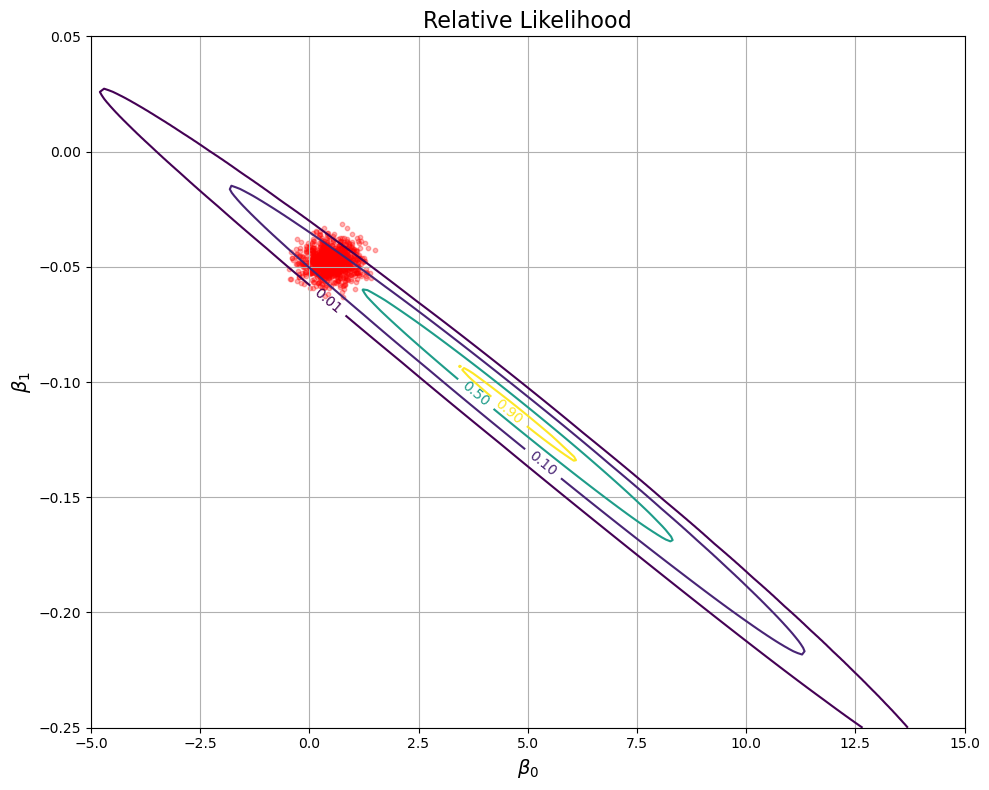

In [67]:
# Define log-likelihood function
temp = X.numpy()
failure = y.numpy()

def loglik(beta):
    linear = beta[0] + beta[1] * temp
    return np.sum(failure * linear) - np.sum(7 * np.log(1 + np.exp(linear)))

# Grid for beta0 and beta1
beta0 = np.linspace(-5, 15, 200)
beta1 = np.linspace(-0.25, 0.05, 200)
B0, B1 = np.meshgrid(beta0, beta1)
grid = np.stack([B0.ravel(), B1.ravel()], axis=-1)

# Evaluate log-likelihood on the grid
l_vals = np.array([loglik(b) for b in grid])
l_vals = l_vals.reshape(len(beta1), len(beta0))
rel_lik = np.exp(l_vals - np.max(l_vals))

# Contour plot
plt.figure(figsize=(10, 8))
cs = plt.contour(beta0, beta1, rel_lik, levels=[0.01, 0.1, 0.5, 0.9], cmap="viridis")
plt.scatter(beta0_samples.numpy(), beta1_samples.numpy(), alpha=0.3, s=10, color='red', label='Posterior samples')

plt.clabel(cs, inline=True, fontsize=10)
plt.xlabel(r"$\beta_0$", fontsize=14)
plt.ylabel(r"$\beta_1$", fontsize=14)
plt.title("Relative Likelihood", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Step 0 : loss = 2042.1927490234375
Step 50000 : loss = 130.68043661117554
Step 100000 : loss = 108.86247396469116
Step 150000 : loss = 22.44792652130127
Step 200000 : loss = 22.32229232788086
Step 250000 : loss = 22.356318950653076
Step 300000 : loss = 22.34167790412903
Step 350000 : loss = 22.27350425720215
Step 400000 : loss = 23.212278604507446
Step 450000 : loss = 22.027671337127686


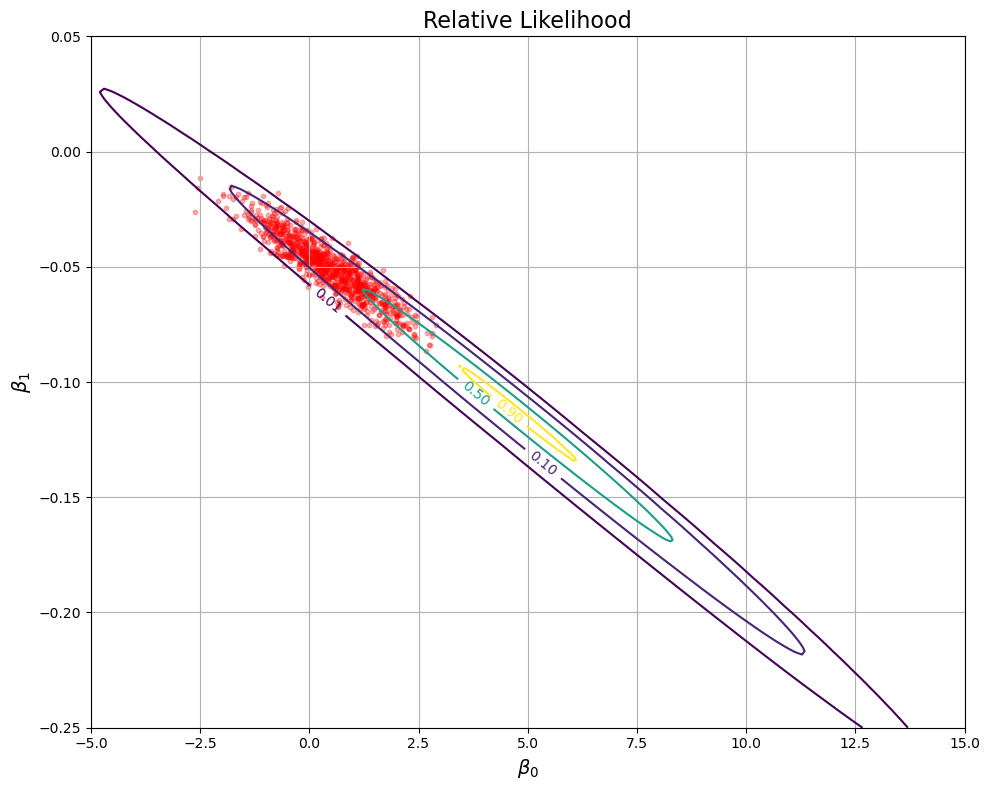

In [ ]:
# Guide: Mean-field variational family
from pyro.distributions import constraints
from torch.distributions import MultivariateNormal


def model(X, y, n_trials):
    beta = pyro.sample("beta", dist.MultivariateNormal(torch.zeros(2), torch.eye(2)))
    beta0, beta1 = beta[0], beta[1]
    logits = beta0 + beta1 * X
    probs = torch.sigmoid(logits)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Binomial(total_count=n_trials, probs=probs), obs=y)

def guide(X, y, n_trials):
    # Mean vector (size 2: [beta0, beta1])
    loc = pyro.param("beta_loc", torch.zeros(2))

    # Lower-triangular Cholesky factor of the 2x2 covariance matrix
    scale_tril = pyro.param(
        "beta_scale_tril",
        torch.eye(2),
        constraint=constraints.lower_cholesky
    )
    # Sample jointly from a Multivariate Normal
    pyro.sample("beta", dist.MultivariateNormal(loc, scale_tril=scale_tril))

# Inference
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.001})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_steps = 500000
for step in range(num_steps):
    loss = svi.step(X, y, n_trials)
    if step % 50000 == 0:
        print(f"Step {step} : loss = {loss}")

# Retrieve learned parameters from the guide
loc = pyro.param("beta_loc")  # shape: [2]
scale_tril = pyro.param("beta_scale_tril")  # shape: [2, 2]

# Construct the MultivariateNormal
posterior = MultivariateNormal(loc, scale_tril=scale_tril)

# Sample
n_samples = 1000
beta_samples = posterior.sample((n_samples,))  # shape: [n_samples, 2]

# Split into individual components if needed
beta0_samples = beta_samples[:, 0]
beta1_samples = beta_samples[:, 1]

# Contour plot
plt.figure(figsize=(10, 8))
cs = plt.contour(beta0, beta1, rel_lik, levels=[0.01, 0.1, 0.5, 0.9], cmap="viridis")
plt.scatter(beta0_samples.numpy(), beta1_samples.numpy(), alpha=0.3, s=10, color='red', label='Posterior samples')

plt.clabel(cs, inline=True, fontsize=10)
plt.xlabel(r"$\beta_0$", fontsize=14)
plt.ylabel(r"$\beta_1$", fontsize=14)
plt.title("Relative Likelihood", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

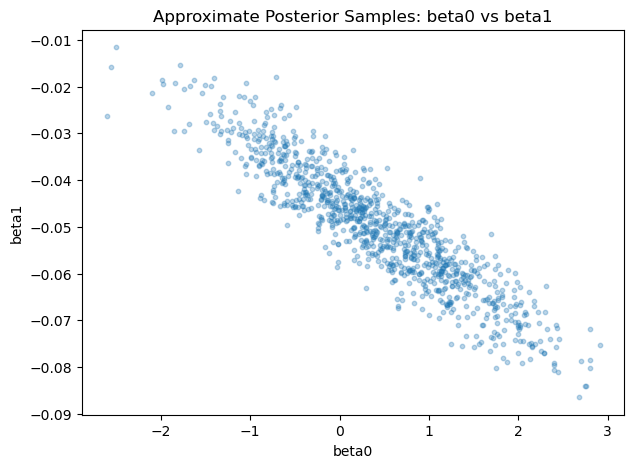

In [65]:
plt.figure(figsize=(7, 5))
plt.scatter(beta0_samples, beta1_samples, alpha=0.3, s=10)
plt.xlabel("beta0")
plt.ylabel("beta1")
plt.title("Approximate Posterior Samples: beta0 vs beta1")
plt.show()

In [ ]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

shuttle_pars = {'beta_0': 0., 'beta_1': 0., 'p1': 0.33, 'p2': 0.33, 'p3': 0.34}
#vi_pars_init = {'muw1': -0.5 , 'muw2': 2., 'muw3': -1., 'muw4': -3., 'mub1': 1., 'mub2': -2., 'mub3': 0.5}


for key, value in shuttle_pars.items():
    shuttle_pars[key] = torch.tensor(value, requires_grad=True)    


compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/shuttle.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

lr = 0.001
steps = 2000

#optimize(bnn_one_pars, neg_log_likelihood, Y.squeeze(-1).t(), cfg, steps=100, lr = 0.0001)

optimizer = torch.optim.Adam([shuttle_pars['beta_0'],shuttle_pars['beta_1']], lr)

total_start = time()

for i in range(steps):

    optimizer.zero_grad()  # Reset gradients
    loss = 0
    for j in range(len(y)):
        yj = y[j].to(torch.float64)
        xj = X[j]
        
        pi= torch.exp(shuttle_pars['beta_0']+ shuttle_pars['beta_1'] * xj)
        pi = pi / (1 + pi)

        current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')

        loss += neg_log_likelihood_one(yj, current_dist)

    # Backpropagate
    loss.backward(retain_graph=True)
    
    optimizer.step()

    # Print progress
    if i % int(steps/10) == 0:
        out = ''
        
        out = out + f" loss: {loss.item()}"

        for key in bnn_one_pars.keys():
            out = out + key + ': ' + str(bnn_one_pars[key].item()) + ' '
            
        print(out)

    total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))

NameError: name 'bnn_one_pars' is not defined

In [73]:
len(y)

23